# Readings

## Dataset
https://www.kaggle.com/jvanelteren/boardgamegeek-reviews

## Fast AI Collaborative Filtering
https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson4-collab.ipynb

## Medium Article
https://towardsdatascience.com/various-implementations-of-collaborative-filtering-100385c6dfe0
https://towardsdatascience.com/collaborative-filtering-with-fastai-3dbdd4ef4f00

## Worth Reading - if have the time
https://medium.com/datadriveninvestor/how-to-built-a-recommender-system-rs-616c988d64b2

## Youtube Video
https://www.youtube.com/watch?v=h9gpufJFF-0&fbclid=IwAR3vS-BP0RnyzfvO4FJeyhLuKo-cWZXXOtXRTFq_btJJ2NjR67foAdTu5gM
https://www.youtube.com/watch?v=Svz02ezIbnE - Book Example with Fast AI, what we based our model on

## Keras - Deep Learning Model
https://towardsdatascience.com/building-a-book-recommendation-system-using-keras-1fba34180699

## Basic Model - Memory constraints, won't run on PC because our dataset is too big
https://www.kaggle.com/kanncaa1/recommendation-systems-tutorial

In [21]:
import pandas as pd
from fastai.collab import *
from sklearn.neighbors import NearestNeighbors

In [22]:
# Import List of Games
gamelist_filename = '2019-05-02.csv'
reviewlist_filename = 'bgg-13m-reviews.csv'
games = pd.read_csv(gamelist_filename)
# games.describe()

In [23]:
games.sort_values('Users rated',ascending=False,inplace=True)
games.rename(index=str, columns={"Bayes average": "Geekscore",'Name':'name'}, inplace=True)

In [4]:
# Import Reviews
reviews = pd.read_csv('bgg-13m-reviews.csv', index_col = 0);

C:\Users\Jerry\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
reviews.head()

,user,rating,comment,ID,name
0,sidehacker,10.0,NaN,13,Catan
1,Varthlokkur,10.0,NaN,13,Catan
2,dougthonus,10.0,"Currently, this sits on my list as my favorite...",13,Catan
3,cypar7,10.0,"I know it says how many plays, but many, many ...",13,Catan
4,ssmooth,10.0,NaN,13,Catan


In [6]:
# Group the reviews by game, get the rating column and aggregate each group by with its mean and count
games_by_all_users = reviews.groupby('name')['rating'].agg(['mean','count'])
games_by_all_users.sort_values('mean',ascending=False, inplace=True)

# How many games with ratings/reviews
# Machine learning does recommendation on top X games.

In [7]:
games_by_all_users

,mean,count
name,,
Limbo: Eternal War,9.597143,35
Animator vs Animation,9.588235,34
TerroriXico,9.428571,70
Arena: The Contest,9.409091,99
Court of the Dead: Mourners Call,9.333519,54
...,...,...
BreaKey,1.546279,43
Overturn: Rising Sands,1.455556,90
W.W.B,1.423384,43


In [8]:
# Create a Data Bunch, a data object used by the learner
data = CollabDataBunch.from_df(reviews, user_name='user', item_name='name', rating_name='rating', seed=42)

In [58]:
data.show_batch()
reviews.rating.min(), reviews.rating.max()

user,name,target
Gadium,Dice Hospital,7.0
tedacuen,Timeline: Events,7.0
seanjoleary,Isle of Skye: From Chieftain to King,7.0
zd2046,Samurai,8.0
davakon,Black Stories 2,8.0


(1.4013e-45, 10.0)

## EmbeddingDotBias Model

In [59]:
learner = collab_learner(data, n_factors=50, y_range=(2.,10))
print(learner.summary())

EmbeddingDotBias
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [50]                 13,926,300 True      
______________________________________________________________________
Embedding            [50]                 836,800    True      
______________________________________________________________________
Embedding            [1]                  278,526    True      
______________________________________________________________________
Embedding            [1]                  16,736     True      
______________________________________________________________________

Total params: 15,058,362
Total trainable params: 15,058,362
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss function : FlattenedLoss
Callbacks functions applied 



In [11]:
# Find a good learning rate
# lr_find(learner)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


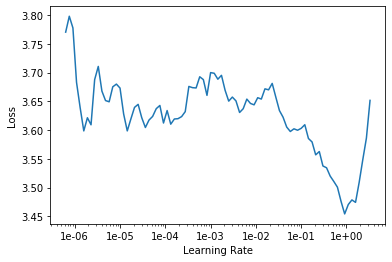

In [12]:
# learner.recorder.plot()

In [13]:
# learner.fit_one_cycle(3, 1e-2, wd=0.15)


epoch,train_loss,valid_loss,time
0,2.332111,2.314130,23:33
1,2.297813,2.257733,23:47
2,2.104625,2.111950,23:51


In [81]:
# learner.save("trained_model", return_path=True)
learner.load("trained_model");

In [16]:
learner.model

EmbeddingDotBias(
  (u_weight): Embedding(278526, 50)
  (i_weight): Embedding(16736, 50)
  (u_bias): Embedding(278526, 1)
  (i_bias): Embedding(16736, 1)
)

C:\Users\Jerry\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\Jerry\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


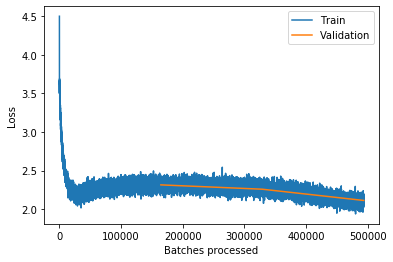

In [17]:
learner.recorder.plot_losses()

In [18]:
mean_ratings = reviews.groupby('name')['rating'].mean().round(2)


In [20]:
# Games where there are over 5000 ratings
top_games = games_by_all_users[games_by_all_users['count']>5000].sort_values('mean',ascending=False).index

In [22]:
# Number of games with over 5000 ratings
print(len(top_games))

530


In [52]:
# High bias, generally means the book is rated higher, low bias means the game is rated poorly
game_bias = learner.bias(top_games, is_item=True)
game_bias.shape

torch.Size([530])

In [25]:
game_bias.shapemean_ratings = reviews.groupby('name')['rating'].mean()

In [27]:
# game_bias

In [28]:
game_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_games,game_bias)]

In [29]:
item0 = lambda o:o[0]

In [61]:
# Top Games
sorted(game_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(1.0505), 'Gloomhaven', 8.9),
 (tensor(0.9571), 'Pandemic Legacy: Season 1', 8.64),
 (tensor(0.9459), 'Terraforming Mars', 8.4),
 (tensor(0.8582), 'Scythe', 8.29),
 (tensor(0.8437), 'Twilight Struggle', 8.33),
 (tensor(0.8218), 'Through the Ages: A New Story of Civilization', 8.54),
 (tensor(0.8199), '7 Wonders Duel', 8.12),
 (tensor(0.7990), 'Puerto Rico', 8.04),
 (tensor(0.7988), 'Terra Mystica', 8.19),
 (tensor(0.7983), 'Star Wars: Rebellion', 8.45),
 (tensor(0.7932), 'The Castles of Burgundy', 8.13),
 (tensor(0.7803), 'Great Western Trail', 8.29),
 (tensor(0.7643), 'Agricola', 7.99),
 (tensor(0.7286), 'Arkham Horror: The Card Game', 8.22),
 (tensor(0.7279), 'Viticulture Essential Edition', 8.15)]

In [62]:
# Vector Space Representation of the Board Games

## Find Similar Games

In [65]:
# Want games with at least 50 reviews

In [132]:
top_games = games_by_all_users[games_by_all_users['count']>100].sort_values('mean',ascending=False).index

In [133]:
print(len(top_games)) # There are 13107 games with at least 50 reviews

9196


In [134]:
game_bias = learner.bias(top_games, is_item=True)

In [135]:
game_bias

tensor([ 0.0473,  0.0713,  0.1888,  ..., -0.2766, -0.4838, -0.0298])

In [136]:
shapemean_ratings = reviews.groupby('name')['rating'].mean()

In [150]:
game_bias

tensor([ 0.0473,  0.0713,  0.1888,  ..., -0.2766, -0.4838, -0.0298])

In [138]:
shapemean_ratings

name
"La Garde recule!"                                                              5.540323
"Oh My God! There's An Axe In My Head." The Game of International Diplomacy     6.020533
"Scratch One Flat Top!"                                                         7.354889
"Tarleton's Quarter!"                                                           7.150000
'65: Squad-Level Combat in the Jungles of Vietnam                               7.633178
                                                                                  ...   
ひとひら (Hitohira)                                                                 6.486053
ふくろと金貨 (Moneybags)                                                              5.777778
メトロックス (MetroX)                                                                 7.078975
猿道 (Monkey Road)                                                                5.900270
老師敬服 (Master of Respect)                                                        7.269783
Name: rating, Le

In [139]:
game_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_games,game_bias)]

In [117]:
game_ratings;

In [153]:
game_weights = learner.weight(top_games, is_item=True)
game_weights.shape
game_pca = game_weights.pca(3)
game_pca.shape
game_np_weights = game_pca.numpy()
game_np_weights
game_weights = game_weights.numpy()

In [179]:
nn = NearestNeighbors(n_neighbors=len(top_games))
fitnn = nn.fit(game_np_weights)

In [181]:
distance, neighbours = fitnn.kneighbors(X=[game_np_weights[1]], n_neighbors=5)

In [180]:
def getRecommendations( game, n_recommendations):
    distance, neighbours = fitnn.kneighbors(X=[game_np_weights[game]], n_neighbors=5)
    recommand_list=[]
    for i,value in enumerate(neighbours, start=0):
        print(top_games[value], distance[i])
        recommand_list.append(top_games[value])

In [182]:
getRecommendations(1, 5)

Index(['Time of Legends: Joan of Arc', 'Anima: Beyond Good and Evil',
       'Scuttle!', 'DAK', 'Great War at Sea: The Mediterranean'],
      dtype='object', name='name') [0.       0.001556 0.001569 0.001934 0.003005]


In [173]:
top_games[1]

'Time of Legends: Joan of Arc'

In [155]:
nn2 = NearestNeighbors(n_neighbors=len(top_games))
fitnn2 = nn2.fit(game_weights)

In [184]:
distance, neighbours = fitnn2.kneighbors(X=[game_weights[1]], n_neighbors=5)

In [185]:
for i,value in enumerate(neighbours, start=0):
    print(top_games[value], distance[i])

Index(['Time of Legends: Joan of Arc', 'Helvetia Cup', 'Bangkok Klongs',
       'VektoRace', 'Hero of Weehawken'],
      dtype='object', name='name') [0.       0.009033 0.009997 0.010024 0.010199]


In [172]:
neighbours

array([[   1, 3164, 5786,   80,  813]], dtype=int64)

In [24]:
#output the recommand list
games.set_index("name",inplace =True)
games.loc[recommand_list]

,ID,Year,Rank,Average,Geekscore,Users rated,URL,Thumbnail
name,,,,,,,,
Time of Legends: Joan of Arc,230791,2019,3884,9.04,5.734,281,/boardgame/230791/time-legends-joan-arc,https://cf.geekdo-images.com/micro/img/bU7uQlo...
Helvetia Cup,128218,2012,4865,6.85,5.662,179,/boardgame/128218/helvetia-cup,https://cf.geekdo-images.com/micro/img/hSv76YA...
Bangkok Klongs,82424,2010,5102,6.29,5.651,298,/boardgame/82424/bangkok-klongs,https://cf.geekdo-images.com/micro/img/ZsUIgji...
VektoRace,256839,2018,3464,8.33,5.778,190,/boardgame/256839/vektorace,https://cf.geekdo-images.com/micro/img/E27zZ0M...
Hero of Weehawken,100169,2011,4022,7.58,5.722,149,/boardgame/100169/hero-weehawken,https://cf.geekdo-images.com/micro/img/-nAi3ZY...
